# CAB420 DCNNs, Bonus Example: Explaining Neural Network Decisions
Dr Simon Denman (s.denman@qut.edu.au)

### What is a "Bonus" Example?

These are extra examples that cover content outside the scope of CAB420. It exists becuase of one or more of the following reasons:
* It's closely related to other stuff we're looking at and I wanted to include it, but the course has too much content already, so I punted it here; 
* It's interesting;
* Someone (probably multiple someones if I wrote an example) has asked a question about it before.

You can freely ignore this example if you want. You really don't have to be reading this. You could go outside, go read a book, have a nap, take up a hobby, whatever you want really. The point I want to make here **this example really is optional**. Things here won't appear on an exam, or in an assignment (though you could use this in an assignment if you wanted). But if you're interested, this is here, and if you're reading this, so are you. 

Some things to note with bonus examples:
* These may gloss over details that elsewhere get more coverage. I may skip plots I'd normally include, or gloss over other details. The expecatation is that if you're reading this, you've looked at all the "core" examples and are comfortable with what they're doing. 
* Some bits of code might not be as well explained or explored as you're used to in the other examples. These examples are here for interested students looking to extend their knowledge, and I'm assuming if you're here, you're comfortable figuring code out, debugging stuff, and generally googling about to help work out what something is doing.
* There's no Tl;DR section at the top. If you're here, I'm assuming it's because you're interested and want all the gory details and don't just need the quick summary at the top.
* While my regular examples (the "core" ones) certainly contain their fare share of silly remarks and typos, expect the level of flippancy and the prevalence of typos increase in a bonus example. 

That said, as always, if you are stuggling to follow what I've got in here please shoot me a message. The aim is still for this to be clear enough to follow afterall.

## Overview

Neural networks have lots of parameters. Where as with simpler models, like regression, or random forests, we can inspect parameters and attach meaning to them, this is harder with a neural network. In recent years a variety of techniques have sprung up to help understand the decisions neural networks make (and some such like methods, like Shapley values, work on non-deep models as well). This example will have a look at two methods (the links below were used as a basis for what's in this example):
* [SHAP (SHapley Additive exPlanations](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16#)
* [Grad-CAM](https://keras.io/examples/vision/grad_cam/) 

There are way more methods than these out there, but this will serve as a starting point if this is something that's of interest.

### SHAP

SHAP uses Shapely values, which come to us from game theory. Shapely values were proposed to deal with this problem of credit attribution, i.e. if you have some event which a group of individuals contribute towards, how do you attribute credit between the individuals. Applying this to machine learning models, we can think of each feature as an individual, and thus we seek to determine how important each feature is with respect to the model prediction. (If you're keen, there's a good discussion of the credit attribution problem and Shapely values [here](https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d)).

For a given prediction, SHAP assigns each feature an importance value, indicating how it contributes to the prediction. They do this by considering what would happen if the feature in question took some baseline value, and compare this to what happens when it takes the value in question. As an example, consider an image processing task. Each pixel is a feature. So for a given pixel, we'd look at what would happen if that pixel took on some "average" value, and look at how that changes the result. If this idea of a "baseline" value seems odd, it's because this itself is an approximation for what would happen if the feature was missing (which *does* seem a much more sensible way to decice how important a feature is), but as it's (in most cases) really hard to evaluate a model with a feature missing, this baseline value approximation is used.

### Grad-CAM

Grad-CAM is a *class discriminative localisation map*. For a given class, Grad-CAM will create an image that shows which parts of the image correspond to the class in question, with parts that correspond more strongly having bigger values, i.e. a heat-map. To do this, Grad-CAM computes a weighted sum of convolution filter outputs, with the weights determined based on the gradients between the output class in question and the convolution layer. Usually we use Grad-CAM with the last convolution layer, but you don't have to. As with SHAP there's lots of places going into lots of detail on Grad-CAM ([here](https://glassboxmedicine.com/2020/05/29/grad-cam-visual-explanations-from-deep-networks/) is a good option) if you're interested.

Perhaps most of note with Grad-CAM is the other uses that it may have. For example, you can use Grad-CAM to roughly localise or even segment the thing of interest in the image, by finding the maximum point (or all pixels above some value for segmentation) in the heat-map. This means that you can train your network for classification, giving it just images labelled as containing thing X or thing Y, and then use Grad-CAM to locate *where* in the image some instance of thing X (or Y) is. Obviously there's no guarnatee that it will be remotely accurate for this, but in generally it actually does ok. The example that we look at here won't showcase this as the dataset we use here (Fashion-MNIST, what else?) has everything centred and of uniform size, but it's nonetheless a cool alternate use of Grad-CAM.

### Where does this fit into all the other CAB420 content?

This fits with the other DCNN content, and is probably an extension of ``CAB420_DCNNs_Example_3_What_Does_the_Network_Learn.ipynb``, which started to discuss ideas around understanding and interpreting neural networks.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import shap
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## The Data

It's Fashion-MNIST again.

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(60000, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(10000, 28, 28, 1).astype("float32") / 255.0
y_train = y_train.reshape(60000,)
y_test = y_test.reshape(10000,)

## The Model

I'm going to keep the model fairly simple, just a very basic neural network. Feel free to modify this and make it more complex if you wish.

One thing to note is that I'm naming the last convolutional layer. This allows me to easily access that layer within the model, which I'll need to do when computing Grad-CAM.

Model training will be straight forward here. I'll simply train for 10 epochs, using Sparse CCE (I haven't convered the y values to a one-hot representation).

In [3]:
# 28x28x1 input, Fashion-MNIST
inputs = keras.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(8, (3, 3), activation='relu')(inputs)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Conv2D(16, (3, 3), activation='relu', name='second_last_conv')(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
# last convolution layer, this is named for easy reference later
x = keras.layers.Conv2D(32, (3, 3), activation='relu', name='last_conv')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(32, activation='relu')(x)
# no activation, I'll use sparse CCE with from_logits=True
outputs = keras.layers.Dense(10, activation=None)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="test_for_shap")

# compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

# train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 10, batch_size = 128, verbose=True)

Epoch 1/10
469/469 [==============================] - 24s 46ms/step - loss: 0.8138 - accuracy: 0.7032 - val_loss: 0.5908 - val_accuracy: 0.7832
Epoch 2/10
469/469 [==============================] - 23s 49ms/step - loss: 0.5181 - accuracy: 0.8072 - val_loss: 0.5039 - val_accuracy: 0.8150
Epoch 3/10
469/469 [==============================] - 24s 52ms/step - loss: 0.4511 - accuracy: 0.8360 - val_loss: 0.4471 - val_accuracy: 0.8403
Epoch 4/10
469/469 [==============================] - 24s 51ms/step - loss: 0.4110 - accuracy: 0.8540 - val_loss: 0.4388 - val_accuracy: 0.8401
Epoch 5/10
469/469 [==============================] - 24s 52ms/step - loss: 0.3807 - accuracy: 0.8646 - val_loss: 0.3851 - val_accuracy: 0.8638
Epoch 6/10
469/469 [==============================] - 25s 53ms/step - loss: 0.3582 - accuracy: 0.8727 - val_loss: 0.3801 - val_accuracy: 0.8648
Epoch 7/10
469/469 [==============================] - 25s 52ms/step - loss: 0.3421 - accuracy: 0.8765 - val_loss: 0.3713 - val_accuracy:

## Things to Interpret

To give us something to visualise, we'll find one example of each class that's classified correctly, and one from each class that the model get's wrong.

In [4]:
# class label list
class_names = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']

# Compute predictions on the test set
predictions = model.predict(x_test, verbose=False, batch_size = 128)
# get predicted class
predicted_class = np.argmax(predictions, axis=1)

# storage for correct and incorrect predictions, we want one of each class
x_test_correct = dict()
x_test_incorrect = dict()

# loop through all the test results
for i in range(len(x_test)):
    # correct prediction
    if (predicted_class[i] == y_test[i]):
        # check if we've already got an example of this class
        if y_test[i] not in x_test_correct.keys():
            # if not, add it
            x_test_correct[y_test[i]] = x_test[i]
    # incorrect prediction
    else:
        # chec if we already have an example of this class
        if y_test[i] not in x_test_incorrect.keys():
            # if not, add it
            x_test_incorrect[y_test[i]] = x_test[i]

    # check if we have 10 examples (one of each class) in both sets, if so, break the loop
    if (len(x_test_incorrect) == 10) & (len(x_test_correct) == 10):
        break

# get predictions for both the correct and incorrect samples
# start by building arrays of just the 10 correct and incorrect samples
x_test_correct = [x_test_correct[i] for i in sorted(x_test_correct)]
x_test_correct = np.asarray(x_test_correct)
x_test_incorrect = [x_test_incorrect[i] for i in sorted(x_test_incorrect)]
x_test_incorrect = np.asarray(x_test_incorrect)
# now get the predictions for those arrays of 10 samples
predictions_correct = model.predict(x_test_correct, verbose=False)
predicted_correct_class = np.argmax(predictions_correct, axis=1)
predictions_incorrect = model.predict(x_test_incorrect, verbose=False)
predicted_incorrect_class = np.argmax(predictions_incorrect, axis=1)

## Computing SHAP Values

Shapley values need a *background* set which is used to measure the typical importance of features. A large background set is ideal to get a good approximation of the background distribution. Here, I'll select 1000 samples, at random, from the training set.

We'll use the ``shap`` package to do all the hardwork for us.

In [5]:
# select backgroud for shap
background = x_train[np.random.choice(x_train.shape[0], 1000, replace=False)]
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model, background)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


We'll now plot some SHAP values. Below we've got:
* An image for each class, shown over on the left
* SHAP visualisations that show the attribution of each feature (pixel) towards each class. Unpacking these:
  * Green features are those that contribute positiviely towards the score (i.e. provide support for the decision). This means if we took this feature, and replaced it with the background feature, the score for this class would go *down*
  * Red values contribute negatively towards the score. If we replaced these fatures with the corresponding background feature, the class score would go *up*
  * Yellow features are ones that are unimportant. Essentially, if we replace these features with background features nothing changes. You'll note that all the pixels around the left and right edge (which are black in most images) ae all unimportant.
  
Looking at these images, we see that for the true class, the images are more green than red. Classes that score very close to 0 contain mostly red pixels, while those where there is some ambiguity (consider class groups T-Shirt, Pullover, and Shirt) have a few more green pixels.

Note that the numbers shown in the below plots are *logits*, not the softmax normalised scores. Here, bigger values mean this class is more likely, and the biggest value does denote the final classified class.

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


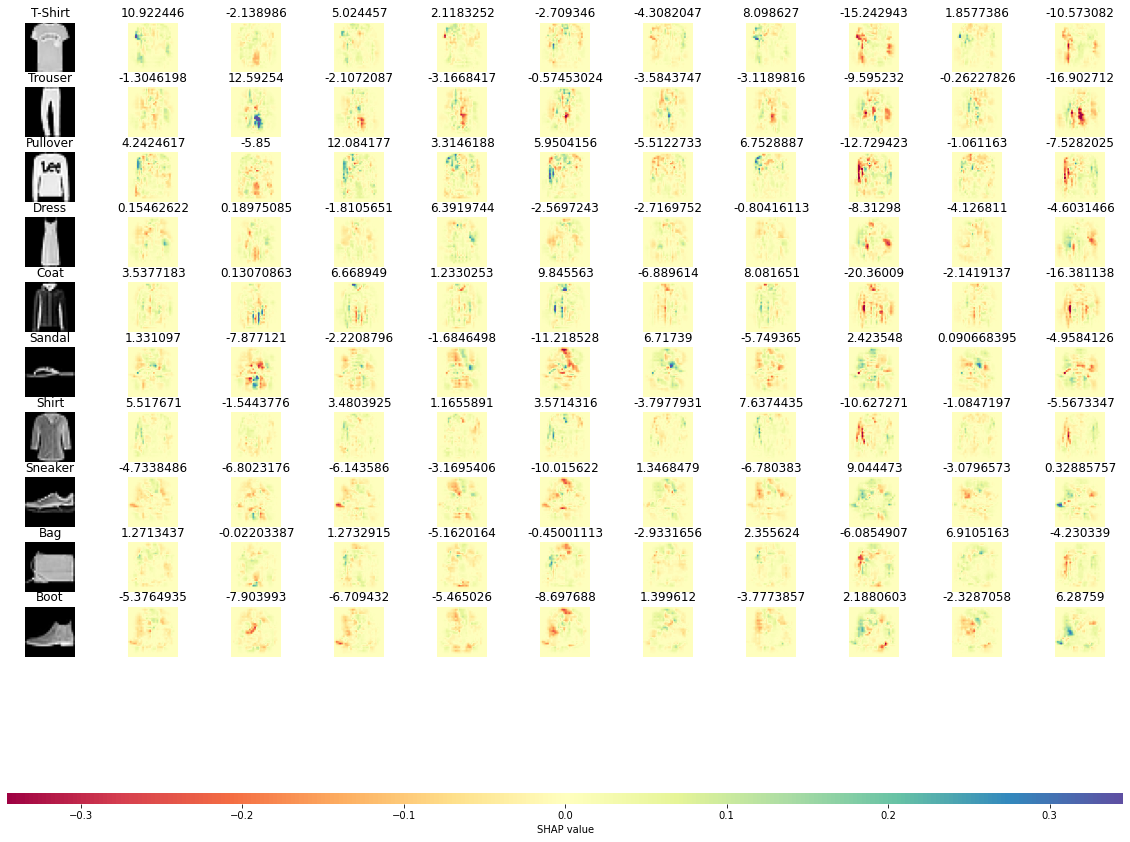

In [6]:
# compute shap values
shap_values = explainer.shap_values(x_test_correct)
# plot shap values
shap.image_plot(shap_values, x_test_correct * 255, true_labels=class_names, \
                labels=predictions_correct, width=20, hspace=0.3, cmap='Spectral')

Looking at examples where the model is wrong now, we can see what features in the data is contributing towards the incorrect decision. 

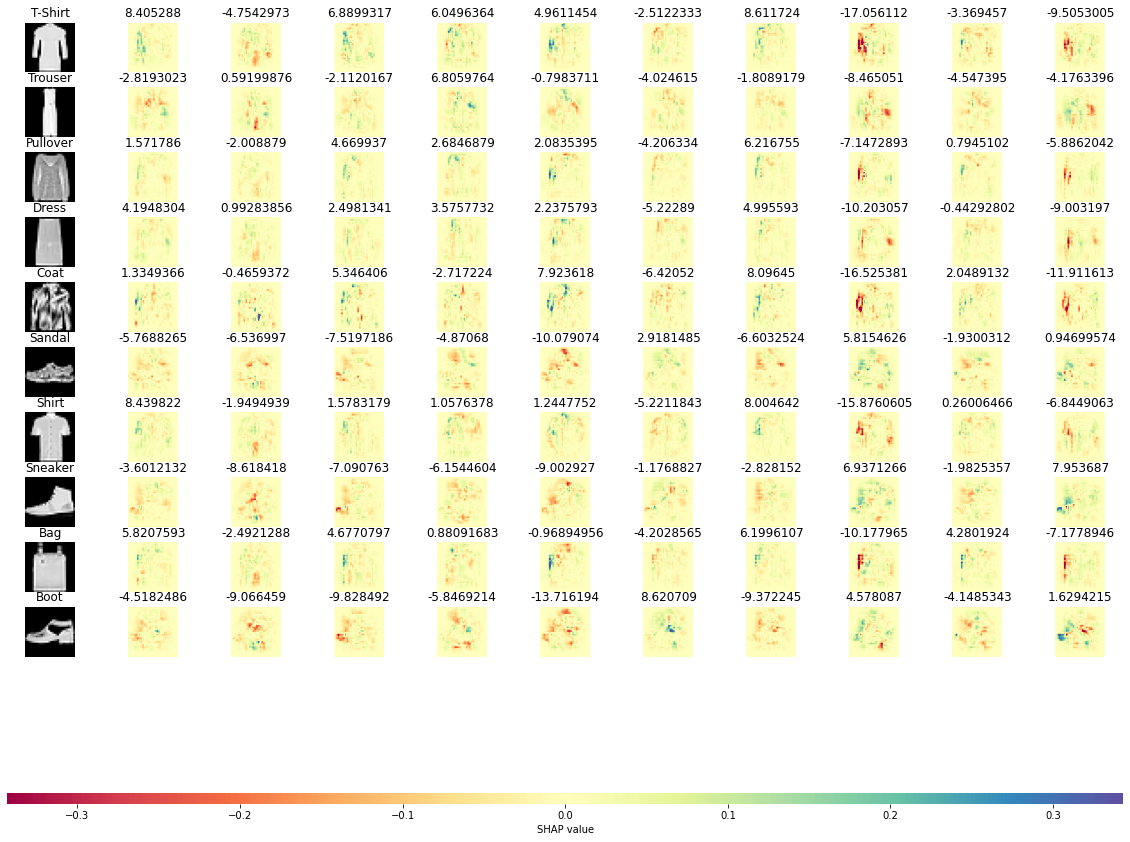

In [7]:
# compute shap values
shap_values = explainer.shap_values(x_test_incorrect)
# plot shap values
shap.image_plot(shap_values, x_test_incorrect * 255, true_labels=class_names, \
                labels=predictions_incorrect, width=20, hspace=0.3, cmap='Spectral')

The SHAP values give us interesting information, telling us which pixels are critical to the decisions. We can see important pixels are (more or less) in little groups or patches, giving us a sense of what regions are important. That said, SHAP is not actually looking at regions explicitly, the region-level importance we're seeing is more to do with how DCNNs operate and the importance of each pixel is considered and measured on it's own.

#### Applying SHAP to other Models

A really cool thing about SHAP is that it works on **any** model. You can use this to do similar analyses on tabular data with an SVM for example. The same package we've used above will allow this, though you'll use a different type of explainer object to make it all work.

## Gradient Class Activation Maps (Grad-CAM)

Grad-CAM is a *class discriminative localisation map*. Basically, an image (or map) which tells us which parts of the image correspond to a particular class. Grad-CAM is computed over convolution filter outputs, and computes a weighted sum of the filters to highlight salient regions. The weights are computed by looking at the gradients between the output (i.e. the predictions) and the layer in question. Generally, this layer in question is the last convolutional layer, but it doesn't need to - you can visualise other feature maps if you wish.

The below code is adapted from [this keras example](https://keras.io/examples/vision/grad_cam/), with changes simply made to look at visualisations across all classes. My implementation below is not optimal (in particular, the looping to get the Grad-CAM map for each class is lazy - a better approach would be to do just one forward pass through the network rather than doing this each time).

In [8]:
# get the gradcam heatmap for a single class
def make_gradcam_heatmap(image, model, last_conv_layer_name, pred_index=None, norm = True):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(image)        
        # apply softmax to get softmax scores
        softmax = tf.nn.softmax(preds)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    if (norm):
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        
    # return heatmap and softmax score for selected class
    return heatmap.numpy(), softmax[:, pred_index].numpy()

# get gradcam heat maps for all classes
# NOTE: this is fine for a small dataset, with a few classes, but I would not recommend this
# approach with bigger datasets
def get_gradcam_for_all_classes(image, model, last_conv_layer_name, num_classes):
    
    heatmaps = []
    scores = []
    # loop through classes
    for i in range(num_classes):
        # get heatmap for ith class, do not normalise heatmaps
        h, s = make_gradcam_heatmap(image, model, last_conv_layer_name, pred_index = i, norm = False)
        # save heatmap and score
        heatmaps.append(h)
        scores.append(s[0])
        
    # convert heatmaps to array
    heatmaps = np.array(heatmaps)
    # jointly normalise all heatmaps
    heatmaps = np.clip(heatmaps, 0, None) / np.amax(heatmaps)
    # re-order dimensions
    heatmaps = np.transpose(heatmaps, (1, 2, 0))
    
    return heatmaps, scores

def overlay_gradcam(image, heatmap, alpha=0.4):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + np.uint8(np.repeat(image, 3, axis=2) * 255)
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # return super-imposed image
    return superimposed_img

# display function, intended to work with one sample image from each class
def display_grid(images, model, layer, classes = 10):

    n_img = len(images)
    plt.figure(figsize=(14, 16))

    # top row, contains an image of each class
    for i in range(n_img):
        ax = plt.subplot(n_img + 1, classes + 1, (i + 2))                 
        ax.axis('off')
        ax.imshow(np.uint8(np.repeat(images[i,:,:,0:1], 3, axis=2) * 255))
        ax.set_title(class_names[i])

    # main grid
    for i in range(n_img):
        # class being evaluated
        ax = plt.subplot(n_img + 1, classes + 1, (i + 1)*(classes + 1) + 1)                 
        ax.axis('off')
        ax.imshow(np.uint8(np.repeat(images[i,:,:,0:1], 3, axis=2) * 255))
        ax.set_title(class_names[i])

        # get grad-cam for all classes
        h, s = get_gradcam_for_all_classes(images[i:i+1,:,:,:], model, 'last_conv', classes)

        # grad-cam visualisaton showing activations for image i with respect to class j
        for j in range(classes):            
            m = overlay_gradcam(images[i,:,:,:], h[:,:,j])
            ax = plt.subplot(n_img + 1, (classes + 1), (i + 1)*(classes + 1) + 1 + j + 1)
            ax.axis('off')
            ax.set_title('%1.3f' % s[j])
            ax.imshow(m)
       

First up, let's look at the last convolution layer for samples that were predicted correctly.

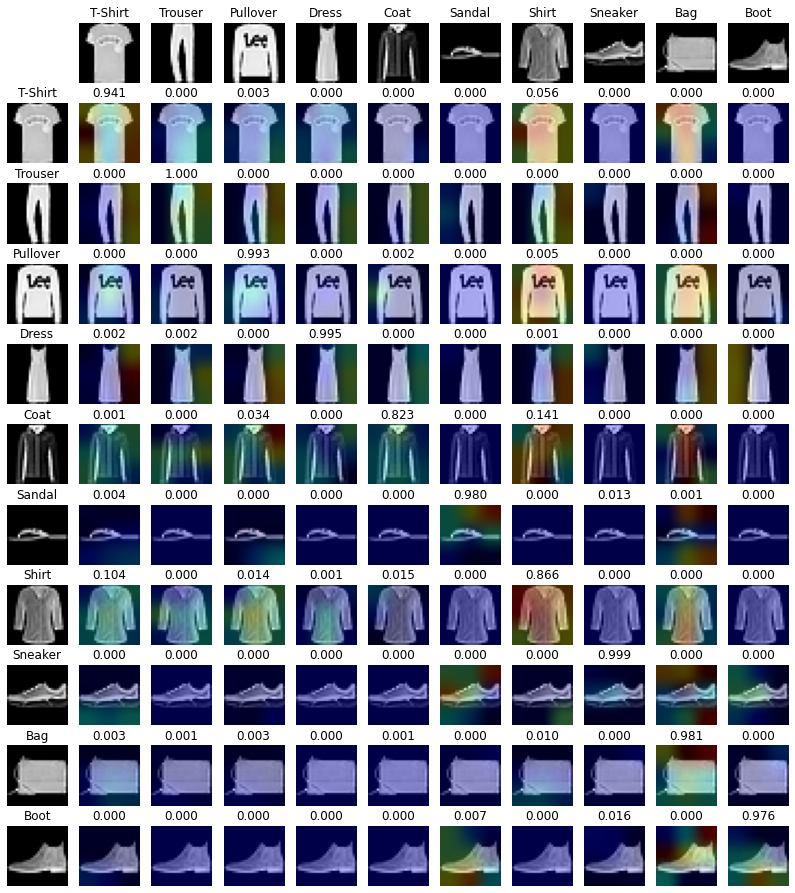

In [9]:
display_grid(x_test_correct, model, 'last_conv')

We see, for the most part:
* Responses are strongest along the diagonal, i.e. for the correct class
* In plenty of cases, the Grad-CAM maps shows nothing is being activated, i.e. the model sees nothing in the image that suggests a given classes
* The same region can be relevant to multiple classes
* The strongest activations in the Grad-CAM map don't necessarily correspond to the predicted class

Now for the incorrect samples.

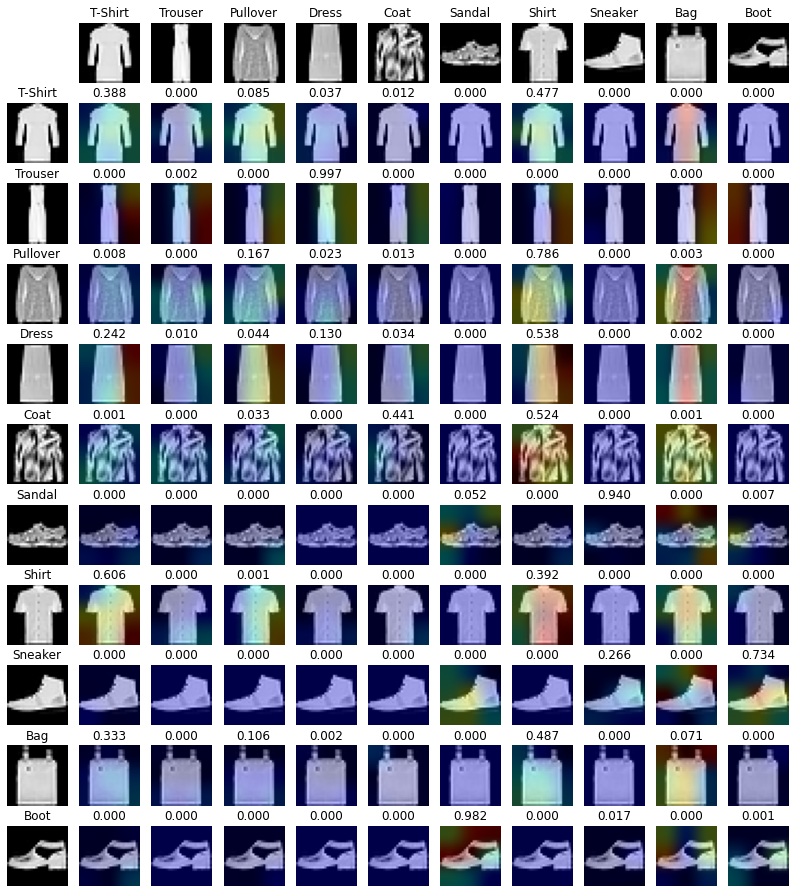

In [10]:
display_grid(x_test_incorrect, model, 'last_conv')

Here we can get a sense of where the model is being confused, i.e. what in the image is leading to the mis-classification. The visualisations here are less fine-grained than we saw with SHAP as we're no longer looking at individual pixels, but rather at regions.

Depending on what convolution layer we draw from, we can get more (or less) spatial resolution. If we work of the second last convolution layer (also known as the second convolution layer in our model) we get a bit more spatial resolution in our Grad-CAM maps.

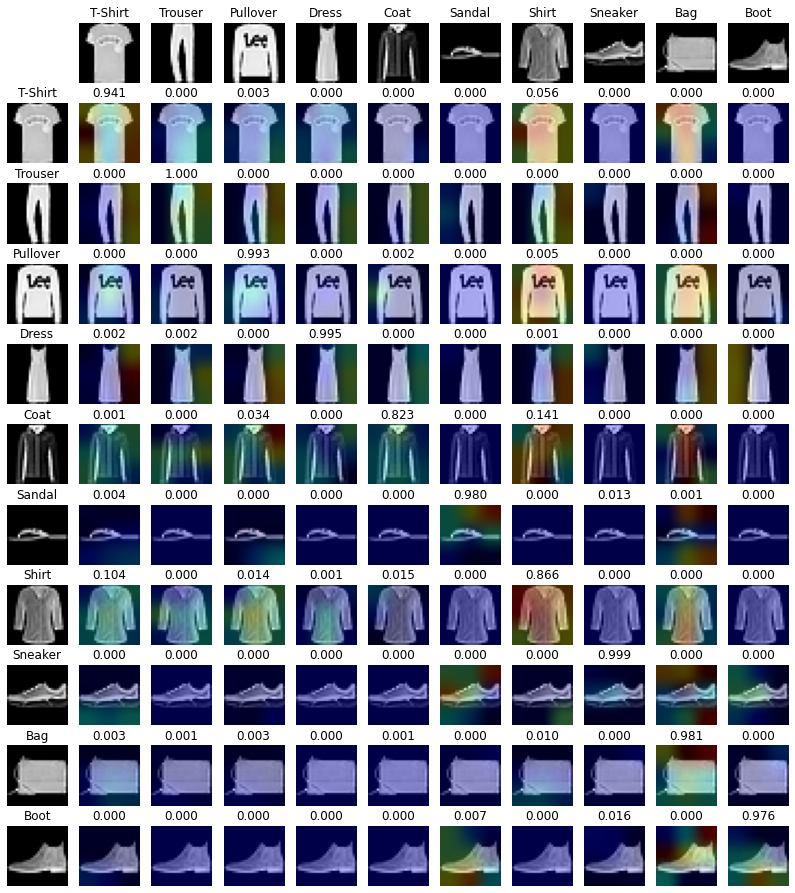

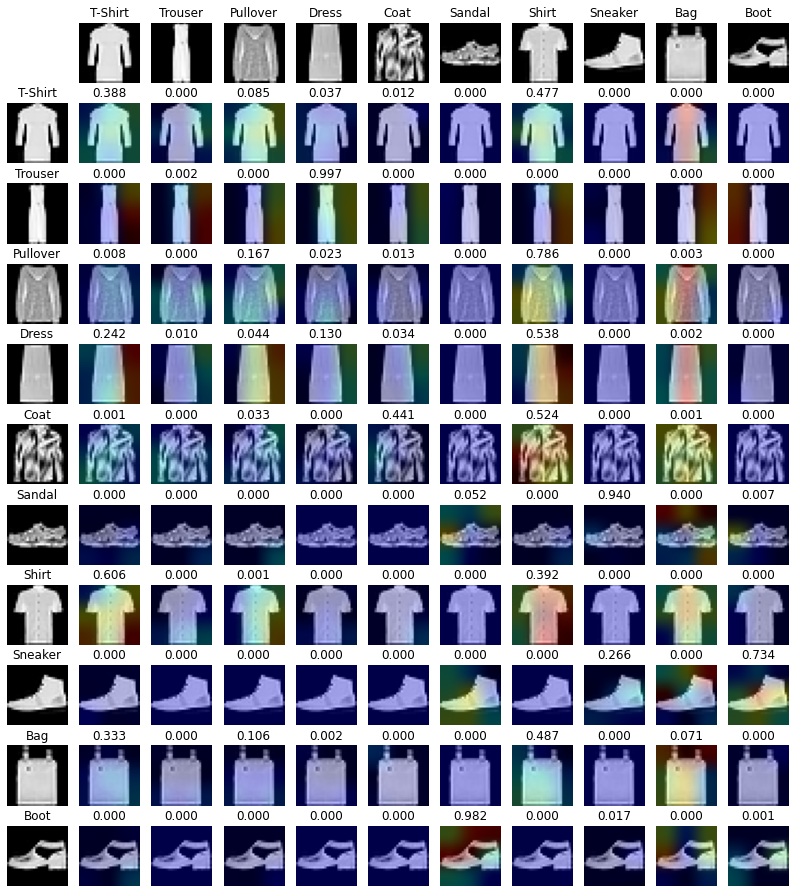

In [11]:
display_grid(x_test_correct, model, 'second_last_conv')
display_grid(x_test_incorrect, model, 'second_last_conv')

This perhaps helps us see a bit more detail - but the features are also taken from higher up the model, so they are less representitive of the final decision, though there is still a strong degree of correlation between the visualisations of the last and second last convolutional layers.